## Computer Vision - Assignment 1  

#### Maggie Ezzat Gamil Gaid       T-16       37-575   
#### Mariz Samir Mounir Awad      T-12       37-


### Problem 1:

#### Imports Used:

In [1]:
from PIL import Image
import numpy as np 
import math
import matplotlib.pyplot as plt

**Computing the Contrast based on the co-occurrence matrix**

In [2]:
def compute_contrast(img):

    # 256 x 256 matrix, with non existant values in the cooccurence matrix as well
    # this is in order to make the indices as the intensity values
    co_occ = np.zeros((256, 256)).astype(int)

    img = np.array(img)
    for i in range (0,img.shape[0]-1):
        for j in range (0,img.shape[1]):
            x = img[i][j]
            x_south = img[i+1,j]
            co_occ[x][x_south] = co_occ[x][x_south]+1

    contrast =0
    for i in range (0,co_occ.shape[0]):
        for j in range (0,co_occ.shape[1]):
            contrast += co_occ[i][j]* ((i-j)**2)

    return contrast  

In [3]:
#Read the original image
img = Image.open("Ocean.bmp")
#compute its contrast
print(compute_contrast(img))

9631290


In [4]:
def get_line(x1,y1, x2,y2):
    m = (y2-y1)/(x2-x1)
    c = y1 - m*x1
    return (m,c)

In [5]:
def increase_contrast(img, a, b, c, d):
    
    img_arr = np.array(img)

    (m1,c1) = get_line(0,0,a,b)
    (m2,c2) = get_line(a,b,c,d)
    (m3,c3) = get_line(c,d,255,255)

    for i in range (0,img_arr.shape[0]):
        for j in range (0,img_arr.shape[1]):
            x = img_arr[i][j]
            if x<=a:
                y = m1*x + c1
            elif x<=c:
                y = m2*x + c2
            elif x<=255:
                y = m3*x + c3
            else:
                y = 255
            img_arr[i][j] = int(y)
            
    output_img = Image.fromarray(img_arr)
    contrast = compute_contrast(output_img)
    return (output_img, contrast)

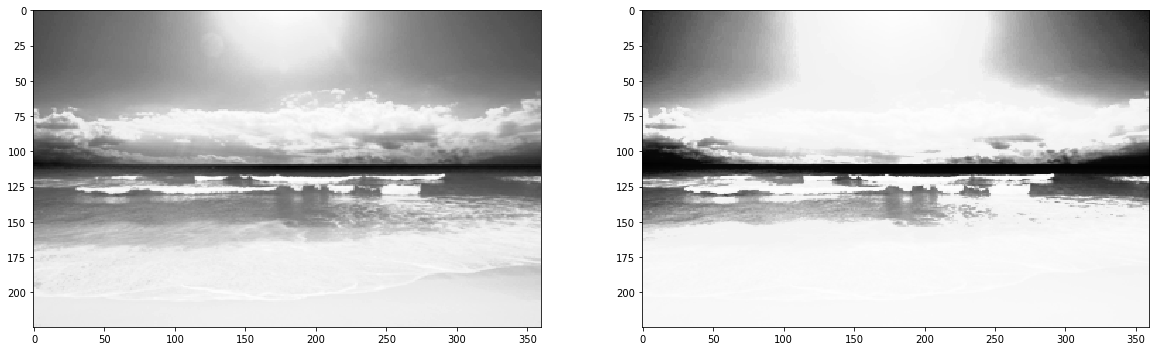

In [6]:
#read the image
img = Image.open("Ocean.bmp")
#image A
(img_a, contrast_a) = increase_contrast(img, 30, 20, 180, 230)
img_a.save('Ocean_a.bmp')
#image B
(img_b, contrast_b) = increase_contrast(img, 70, 20, 140, 240)
img_b.save('Ocean_b.bmp')

#writing the contrast in a text file
with open('contrast.txt', 'w') as f:
    f.write("Ocean_a.bmp contrast: " + str(contrast_a) + '\n')
    f.write("Ocean_b.bmp contrast: " + str(contrast_b) + '\n')
    
#plotting
plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
plt.imshow(img_a, cmap="gray")

plt.subplot(2,2,2)
plt.imshow(img_b, cmap="gray")

### Problem 2:

**Part a: Integral Image Function**

In [7]:
def compute_integral(img):

    img = np.array(img)
    
    #cumulative row sum array
    s_img = np.zeros(img.shape)
    
    #integral image array
    ii_img = np.zeros(img.shape)
    
    #ii_img_python = img.cumsum(axis=1).cumsum(axis=0)

    #compute S which is cumulative row sum, use it to compute ii
    for i in range (0,img.shape[0]):
        for j in range (0,img.shape[1]):
            if j==0:
                s_img[i][j] =  img[i][j]
            else: 
                s_img[i][j] = s_img[i][j-1] + img[i][j]

            if i==0:
                ii_img[i][j] =  s_img[i][j] 
            else:   
                ii_img[i][j] = ii_img[i-1][j] + s_img[i][j]
                

    #perform normalization to make all values between 0 and 255.
    integral_img = ii_img * (255/ ii_img.max())
    integral_img = integral_img.astype('uint8')
    
    #construct the image from the numpy array
    integral_img = Image.fromarray(integral_img)
    
    #return the normalized integral image and the non-normalized one
    return (integral_img, ii_img)

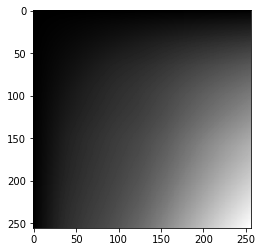

In [8]:
#read the image
img = Image.open("Cameraman_noise.bmp")
#get the normalized integral image
(ii_cameraman_normalized, _) = compute_integral(img)
#save the output image
ii_cameraman_normalized.save('Camera_Integ.jpg')
#plotting
plt.imshow(ii_cameraman_normalized, cmap='gray')

**Part b: Average Filter Function**

In [9]:
def noise_removal_filter(img, filter_size):

    #compute the non-normalized integral image, because we need the actual sum, not the normalized one
    (_, ii_img) = compute_integral(img)

    img = np.array(img)
    
    #same size as the original image, fill with 255 value 
    avg_img = np.full(img.shape, 255, dtype=int)

    b = math.floor(filter_size /2)

    for i in range (b, img.shape[0]-b):
        for j in range (b, img.shape[1]-b):
            #calculating the sum of the neighbours using the integral image
            sum_neighbours = ii_img[i+b][j+b] - ii_img[i+b][j-b-1] - ii_img[i-b-1][j+b] + ii_img[i-b-1][j-b-1]
            #divide by the size of the filter
            filter_value = sum_neighbours / (filter_size * filter_size) 
            #the new value of the pixel
            avg_img[i][j] = int(filter_value)
            
    avg_img = avg_img.astype('uint8')
    #construct the image from the array
    filtered_img = Image.fromarray(avg_img)
    return filtered_img

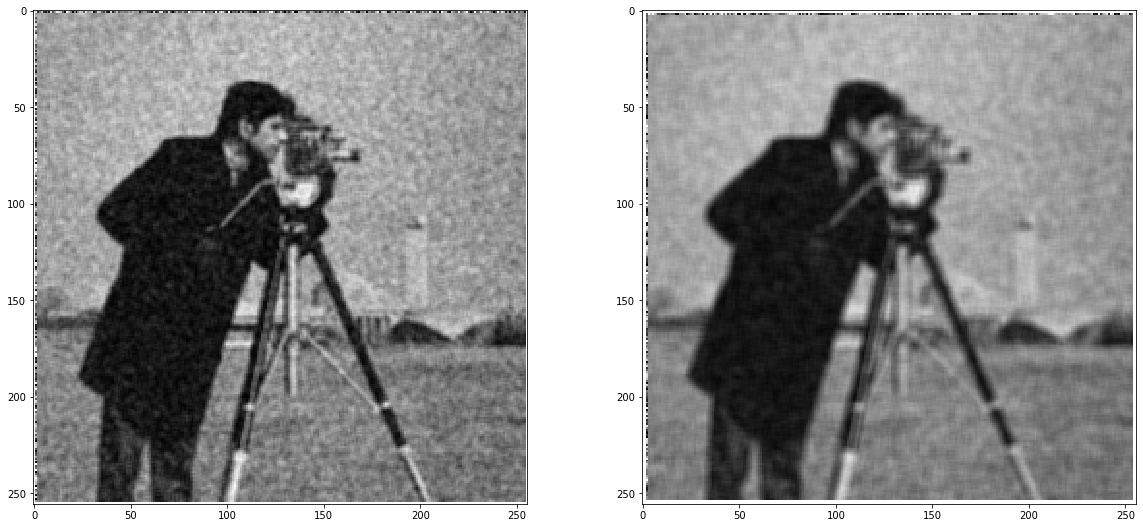

In [10]:
#read the image
img = Image.open("Cameraman_noise.bmp")
#3x3 filter
filter3_img = noise_removal_filter(img, 3)
#5x5 filter
filter5_img = noise_removal_filter(img, 5)

#save the 2 images
filter3_img.save('Camera_Filt_3.jpg')
filter5_img.save('Camera_Filt_5.jpg')

#plotting
plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
plt.imshow(filter3_img, cmap="gray")

plt.subplot(2,2,2)
plt.imshow(filter5_img, cmap="gray")


**Part c:**


Using the integral image is faster as we don't need to compute the neighbours sum for each central pixel, this is redundant. Instead, we compute the integral image only once and extract from it the sum of the regions needed according to the filter size
